# Non-Stiff ODE Solvers

Explore Runge-Kutta methods like RK45, RK23, DOP853 with mathematical explanation and use cases.

## How Runge-Kutta (RK) Methods Work

Runge-Kutta methods are a family of iterative techniques used to solve ordinary differential equations (ODEs) of the form:

$$
\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0
$$

The core idea is to estimate the solution \( y(t) \) by combining multiple evaluations of \( f(t, y) \) at carefully chosen points within each step.


### General RK Formula

$$
y_{n+1} = y_n + h \sum_i w_i k_i
$$

Where:
- \( h \): step size  
- \( k_i \): slope estimates  
- \( a, b, w \): constants from the **Butcher Tableau** (predefined for each RK method, not learned)


###  Each Slope \( k_i \) is Calculated As:

$$
\begin{aligned}
k_1 &= f(t_n, y_n) \\
k_2 &= f(t_n + a_2 h, \; y_n + b_{21} h k_1) \\
k_3 &= f(t_n + a_3 h, \; y_n + b_{31} h k_1 + b_{32} h k_2) \\
&\vdots \\
k_i &= f(t_n + a_i h, \; y_n + \sum_j b_{ij} h k_j)
\end{aligned}
$$

These **weighted slopes** give a more accurate approximation of the true solution across each time step.



##  How It Works (Adaptivity)

Most modern RK methods (like `RK45`) are **adaptive** — they adjust the step size \( h \) based on error estimates:

- Pick a small time step \( h \)
- Compute slopes at multiple points \( k_1, k_2, k_3, \dots \)
- Compute **two solutions**:
  - A **higher-order accurate solution** (e.g. 5th order)
  - A **lower-order estimate** (e.g. 4th order)
- Use their difference to **estimate the local error**
- If error is too big → reduce \( h \), if small → increase \( h \)



###  Tolerance Parameters

- **`rtol`** *(default = 1e-3)*: relative tolerance, controls how much the solution can change **relative to the size of \( y \)**
- **`atol`** *(default = 1e-6)*: absolute tolerance, controls how small the solution can be before it is considered too small to matter

The solver chooses step size \( h \) such that the local error estimate \( e \) satisfies:

$$
e \leq \text{atol} + \text{rtol} \cdot |y|
$$



### 📌 Comparison of Runge-Kutta Methods in `solve_ivp`

| Method     | Order     | Adaptive? | Best For                            | Meaning of Order                             |
|------------|-----------|-----------|-------------------------------------|----------------------------------------------|
| `'RK45'`   | 5(4)      | ✅ Yes    | General use, smooth problems        | 5th-order solution with 4th-order error estimate |
| `'RK23'`   | 3(2)      | ✅ Yes    | Less smooth problems, conservative  | 3rd-order solution with 2nd-order error estimate |
| `'DOP853'` | 8(5,3)    | ✅ Yes    | High accuracy, low-noise problems   | 8th-order solution with embedded 5th and 3rd-order estimates |


- **RK45** is the default — good accuracy at reasonable cost.
- **RK23** is more cautious — useful if the solution has rapid changes or low smoothness.
- **DOP853** gives very accurate results — but can be more computationally expensive.


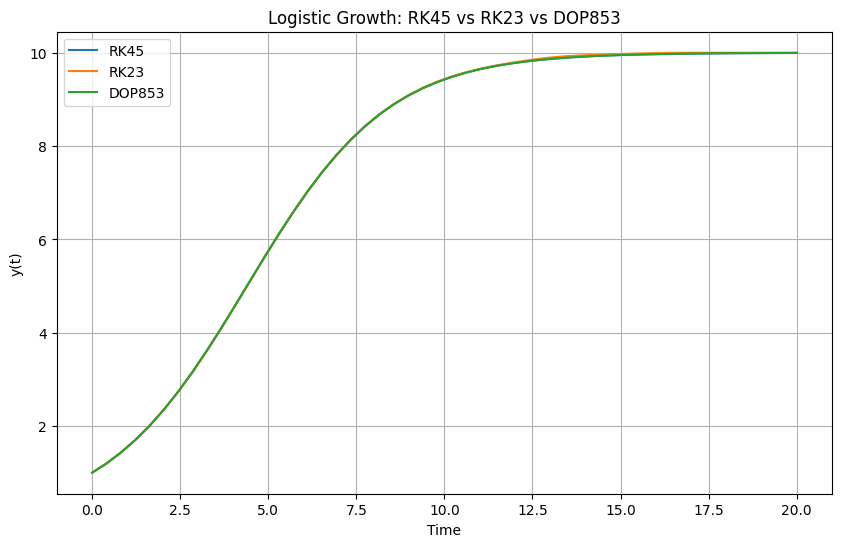

RK45:
  Time     = 0.0025 sec
  Steps    = 50
  Func evals = 62

RK23:
  Time     = 0.0020 sec
  Steps    = 50
  Func evals = 50

DOP853:
  Time     = 0.0030 sec
  Steps    = 50
  Func evals = 104



In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# Define a test ODE: logistic growth
def logistic(t, y):
    return 0.5 * y * (1 - y / 10)

# Initial condition and evaluation times
y0 = [1.0]
t_span = (0, 20)
t_eval = np.linspace(*t_span, 50)

# Solve with each method
methods = ['RK45', 'RK23', 'DOP853']
solutions = {}

for method in methods:
    start = time.time()
    sol = solve_ivp(logistic, t_span, y0, method=method, t_eval=t_eval)
    duration = time.time() - start
    solutions[method] = {
        'sol': sol,
        'time': duration,
        'nfev': sol.nfev,
        'n_steps': len(sol.t)
    }

# Plot solutions
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(solutions[method]['sol'].t, solutions[method]['sol'].y[0], label=f"{method}")
plt.title("Logistic Growth: RK45 vs RK23 vs DOP853")
plt.xlabel("Time")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.show()

# Print performance summary
for method in methods:
    print(f"{method}:")
    print(f"  Time     = {solutions[method]['time']:.4f} sec")
    print(f"  Steps    = {solutions[method]['n_steps']}")
    print(f"  Func evals = {solutions[method]['nfev']}")
    print()



### Understanding `nfev` (Function Evaluations)

`nfev` stands for **number of function evaluations** — how many times the solver called your ODE function `f(t, y)`.

This metric helps understanding how much internal "hard" work the solver did.

---

#### Why It Matters

| Observation | What It Suggests |
|-------------|------------------|
| Low `nfev` | Solver took larger steps or the problem is easy |
| High `nfev` | Solver took many small steps, or retried due to errors |
| Very High `nfev` | ODE system might be stiff, noisy, or hard to solve numerically |


Keep in mind:
- Higher `nfev` = more CPU time
- Use it to evaluate solver efficiency